# Fraud Detection - Multiclass Classification
## Machine Learning I - Group Project

**Objective:** E-commerce fraud detection using multiclass classification (Legitimate, Suspicious, Fraudulent)

**Authors:** [Your Names]  
**Date:** December 2024

---

### Methodology:
- **4 ML Algorithms:** ANNs (8 topologies), SVMs (10 configs), Decision Trees (7 depths), kNN (6 k values)
- **Ensemble Methods:** Majority Voting + Weighted Voting
- **Dataset:** 1.5M e-commerce transactions → 3-class risk assessment
- **Cross-Validation:** 3-fold stratified on training set
- **Evaluation:** Hold-out test set (20%)

### Code Organization:
```
/project/
├── main.jl                    ← This file (executable from top to bottom)
├── /utils/
│   ├── utils.jl              ← Course utilities (includes modelCrossValidation)
│   └── preprocessing.jl      ← Custom preprocessing functions
└── /datasets/
    └── Fraudulent_E-Commerce_Transaction_Data_merge.csv
```

In [1]:
# ============================================================================
#                    SETUP & IMPORTS
# ============================================================================

# Set random seed for reproducibility
using Random
Random.seed!(42)

# Load packages
using CSV
using DataFrames
using Statistics
using Dates
using StatsBase
using Plots
using StatsPlots     
using HypothesisTests
using Pkg

println("✅ Packages loaded!")

# Load course utilities
include("utils/utils.jl")
println("✅ Course utilities loaded (includes modelCrossValidation, confusionMatrix, etc.)")

include("utils/visualization.jl")

# Load custom preprocessing
include("utils/preprocessing.jl")
using .PreprocessingUtils
println("✅ Custom preprocessing utilities loaded!")

✅ Packages loaded!


[ Info: For silent loading, specify `verbosity=0`. 


import MLJLIBSVMInterface ✔
import NearestNeighborModels ✔

[ Info: For silent loading, specify `verbosity=0`. 



import MLJDecisionTreeInterface ✔

[ Info: For silent loading, specify `verbosity=0`. 



✅ Course utilities loaded (includes modelCrossValidation, confusionMatrix, etc.)
✅ Custom preprocessing utilities loaded!


In [2]:
# ============================================================================
#  HELPER FUNCTIONS: ENSEMBLE VOTING
# ============================================================================

function majorityVoting(predictions::Vector{Vector{String}})
    n_samples = length(predictions[1])
    ensemble_predictions = Vector{String}(undef, n_samples)
    for i in 1:n_samples
        votes = [pred[i] for pred in predictions]
        ensemble_predictions[i] = mode(votes)
    end
    return ensemble_predictions
end

function weightedVoting(predictions::Vector{Vector{String}}, weights::Vector{Float64})
    n_samples = length(predictions[1])
    n_models = length(predictions)
    # Raccogli tutte le classi uniche
    classes_unique = sort(unique(vcat(predictions...)))
    
    ensemble_predictions = Vector{String}(undef, n_samples)
    for i in 1:n_samples
        class_scores = Dict(c => 0.0 for c in classes_unique)
        for j in 1:n_models
            class_pred = predictions[j][i]
            if haskey(class_scores, class_pred)
                class_scores[class_pred] += weights[j]
            end
        end
        ensemble_predictions[i] = argmax(class_scores)
    end
    return ensemble_predictions
end

weightedVoting (generic function with 1 method)

In [3]:
function evaluate_approach(approach_name, train_inputs, train_targets, test_inputs, test_targets; cv_folds=3)
    println("\n" * "="^80)
    println("🚀 EVALUATING APPROACH: $approach_name")
    println("="^80)
    
    cv_indices = crossvalidation(train_targets, cv_folds)
    final_results = Dict{String, Dict{String, Float64}}()
    
    # --- PREPARAZIONE DATI ---
    train_targets_str = string.(train_targets)
    test_targets_str = string.(test_targets)
    classes_str = sort(unique(train_targets_str))
    classes_int = sort(unique(train_targets))
    
    # One-Hot Encoding per ANN
    if length(classes_int) == 2
        train_targets_onehot = reshape(train_targets .== classes_int[2], :, 1)
        test_targets_onehot  = reshape(test_targets  .== classes_int[2], :, 1)
    else
        train_targets_onehot = oneHotEncoding(train_targets, classes_int)
        test_targets_onehot = oneHotEncoding(test_targets, classes_int)
    end
    
    normParams = calculateMinMaxNormalizationParameters(train_inputs)
    train_inputs_norm = normalizeMinMax(train_inputs, normParams)
    test_inputs_norm = normalizeMinMax(test_inputs, normParams)

    raw_cv_scores = Dict{String, Vector{Float64}}()

    # --- INTERNAL HELPER: CALCOLO METRICHE ---
    function calculate_metrics_safe(y_pred_probs, y_pred_class, y_true_class, y_true_onehot, classes)
        auc_score = 0.5
        acc, sens, spec, f1 = 0.0, 0.0, 0.0, 0.0
        
        if length(classes) == 2
             # --- CALCOLO AUC REALE ---
             try
                probs = vec(y_pred_probs)
                # Se abbiamo probabilità valide (non tutte zero)
                if sum(probs) > 0
                    true_bin = vec(y_true_onehot)
                    
                    p = sortperm(probs)
                    probs_sorted = probs[p]
                    true_sorted = true_bin[p]

                    tpr = [0.0]; fpr = [0.0]
                    num_pos = sum(true_sorted)
                    num_neg = length(true_sorted) - num_pos

                    if num_pos > 0 && num_neg > 0
                        tp = 0; fp = 0
                        for i in length(probs_sorted):-1:1
                            if true_sorted[i] == 1; tp += 1; else; fp += 1; end
                            push!(tpr, tp/num_pos)
                            push!(fpr, fp/num_neg)
                        end
                        # Regola del trapezio
                        auc_score = 0.0
                        for i in 2:length(tpr)
                            auc_score += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
                        end
                    end
                end
             catch e
                 # println("Debug: AUC calculation failed: $e")
             end
             # --------------------------

             pos_label = classes[end]
             y_p_bool = vec(y_pred_class .== pos_label)
             y_t_bool = vec(y_true_class .== pos_label)
             (acc, err, sens, spec, prec, npv, f1, cm) = confusionMatrix(y_p_bool, y_t_bool)
        else
             cm_res = confusionMatrix(y_pred_class, y_true_class, classes; weighted=true)
             acc, sens, spec, f1 = cm_res.accuracy, cm_res.aggregated.sensitivity, cm_res.aggregated.specificity, cm_res.aggregated.f1
        end
        return Dict("Accuracy"=>acc, "AUC"=>auc_score, "Sensitivity"=>sens, "Specificity"=>spec, "F1"=>f1)
    end
    
    # ========================================================================
    # 1. Artificial Neural Networks (ANNs)
    # ========================================================================
    println("\n[1/5] Testing ANNs...")
    ann_topologies = [[256], [128], [64], [32], [256, 128], [128, 64], [64, 32], [96, 48]]
    best_f1_cv_ann = -1.0; best_topo_ann = []; best_raw_ann = []
    
    for topology in ann_topologies
        hyperparams = Dict("topology" => topology, "learningRate" => 0.003, "validationRatio" => 0.1, 
                           "numExecutions" => 1, "maxEpochs" => 800, "maxEpochsVal" => 25)
        res = modelCrossValidation(:ANN, hyperparams, (train_inputs_norm, train_targets), cv_indices)
        if res[7][1] > best_f1_cv_ann
            best_f1_cv_ann = res[7][1]; best_topo_ann = topology; best_raw_ann = res[9] 
        end
    end
    raw_cv_scores["ANN"] = best_raw_ann
    println("   ✨ Best ANN (CV): $best_topo_ann - CV F1: $(round(best_f1_cv_ann*100, digits=2))%")

    println("      ...Retraining Best ANN & Plotting Loss...")
    N_train = size(train_inputs_norm, 1); (train_idx, val_idx) = holdOut(N_train, 0.1)
    
    final_ann, train_l, val_l, _ = _trainClassANN(best_topo_ann,
        (train_inputs_norm[train_idx, :], train_targets_onehot[train_idx, :]),
        validationDataset=(train_inputs_norm[val_idx, :], train_targets_onehot[val_idx, :]),
        testDataset=(test_inputs_norm, test_targets_onehot),
        maxEpochs=800, learningRate=0.003, maxEpochsVal=25)
    plot_loss_curves(train_l, val_l, title="ANN Loss ($approach_name)")

    test_outputs_ann_raw = final_ann(test_inputs_norm')'
    if size(test_targets_onehot, 2) == 1
        probs_ann = vec(test_outputs_ann_raw); preds_ann_int = Int.(probs_ann .>= 0.5)
    else
        preds_bool = classifyOutputs(test_outputs_ann_raw)
        preds_ann_int = [findfirst(x->x, row) - 1 for row in eachrow(preds_bool)]
        probs_ann = test_outputs_ann_raw # Multiclass AUC placeholder
    end
    final_results["ANN"] = calculate_metrics_safe(probs_ann, preds_ann_int, test_targets, test_targets_onehot, classes_int)
    println("      ✅ ANN Test Results: F1=$(round(final_results["ANN"]["F1"], digits=3))")

    # ========================================================================
    # 2. Support Vector Machines (SVMs)
    # ========================================================================
    println("\n[2/5] Testing SVMs...")
    svm_configs = [
        ("linear", 0.1, 0.125, 3), ("linear", 1.0, 0.125, 3), ("linear", 10.0, 0.125, 3),
        ("rbf", 0.1, 0.125, 3), ("rbf", 1.0, 0.125, 3), ("rbf", 10.0, 0.125, 3), ("rbf", 1.0, 0.1, 3),
        ("poly", 1.0, 0.125, 2), ("poly", 1.0, 0.125, 3), ("poly", 10.0, 0.125, 2)
    ]
    best_f1_cv_svm = -1.0; best_params_svm = (); best_raw_svm = []
    
    for (kernel, C, gamma, degree) in svm_configs
        res = modelCrossValidation(:SVC, Dict("kernel"=>kernel, "C"=>C, "gamma"=>gamma, "degree"=>degree), (train_inputs, train_targets), cv_indices)
        if res[7][1] > best_f1_cv_svm
            best_f1_cv_svm = res[7][1]; best_params_svm = (kernel, C, gamma, degree); best_raw_svm = res[9] 
        end
    end
    raw_cv_scores["SVM"] = best_raw_svm
    k_name, C_val, g_val, d_val = best_params_svm
    println("   ✨ Best SVM (CV): $k_name C=$C_val - CV F1: $(round(best_f1_cv_svm*100, digits=2))%")
    
    k_func = k_name == "linear" ? LIBSVM.Kernel.Linear : (k_name == "poly" ? LIBSVM.Kernel.Polynomial : LIBSVM.Kernel.RadialBasis)
    model_svm = SVMClassifier(kernel=k_func, cost=C_val, gamma=g_val, degree=Int32(d_val))
    mach_svm = machine(model_svm, MLJ.table(train_inputs_norm), categorical(train_targets_str))
    MLJ.fit!(mach_svm, verbosity=0)
    preds_svm_str = string.(MLJ.predict(mach_svm, MLJ.table(test_inputs_norm)))
    # SVM probabilities are tricky/slow in LIBSVM, keeping zeros
    final_results["SVM"] = calculate_metrics_safe(zeros(length(preds_svm_str)), preds_svm_str, test_targets_str, test_targets_onehot, classes_str)
    println("      ✅ SVM Test Results: F1=$(round(final_results["SVM"]["F1"], digits=3))")

    # ========================================================================
    # 3. Decision Trees
    # ========================================================================
    println("\n[3/5] Testing DT...")
    depths = [3, 5, 7, 10, 15, 20, -1]
    best_f1_cv_dt = -1.0; best_depth = 0; best_raw_dt = []
    for d in depths
        res = modelCrossValidation(:DecisionTreeClassifier, Dict("max_depth"=>d), (train_inputs, train_targets), cv_indices)
        if res[7][1] > best_f1_cv_dt
            best_f1_cv_dt = res[7][1]; best_depth = d; best_raw_dt = res[9] 
        end
    end
    raw_cv_scores["DT"] = best_raw_dt
    println("   ✨ Best DT (CV): Depth=$best_depth - CV F1: $(round(best_f1_cv_dt*100, digits=2))%")
    
    model_dt = DTClassifier(max_depth=best_depth, rng=Random.MersenneTwister(42))
    mach_dt = machine(model_dt, MLJ.table(train_inputs_norm), categorical(train_targets_str))
    MLJ.fit!(mach_dt, verbosity=0)
    preds_dt_raw = MLJ.predict(mach_dt, MLJ.table(test_inputs_norm))
    preds_dt_str = string.(mode.(preds_dt_raw))
    
    # Try extract probs for DT
    probs_dt = zeros(length(preds_dt_str))
    try
        # Attempt to get probability of the positive class (usually second class)
        target_class = classes_str[end] 
        probs_dt = pdf.(preds_dt_raw, target_class)
    catch; end

    final_results["DT"] = calculate_metrics_safe(probs_dt, preds_dt_str, test_targets_str, test_targets_onehot, classes_str)
    println("      ✅ DT Test Results: F1=$(round(final_results["DT"]["F1"], digits=3))")

    # ========================================================================
    # 4. kNN
    # ========================================================================
    println("\n[4/5] Testing kNN...")
    k_vals = [1, 3, 5, 7, 10, 15]
    best_f1_cv_knn = -1.0; best_k = 0; best_raw_knn = []
    for k in k_vals
        res = modelCrossValidation(:KNeighborsClassifier, Dict("n_neighbors"=>k), (train_inputs, train_targets), cv_indices)
        if res[7][1] > best_f1_cv_knn
            best_f1_cv_knn = res[7][1]; best_k = k; best_raw_knn = res[9] 
        end
    end
    raw_cv_scores["kNN"] = best_raw_knn
    println("   ✨ Best kNN (CV): k=$best_k - CV F1: $(round(best_f1_cv_knn*100, digits=2))%")
    
    model_knn = kNNClassifier(K=best_k)
    mach_knn = machine(model_knn, MLJ.table(train_inputs_norm), categorical(train_targets_str))
    MLJ.fit!(mach_knn, verbosity=0)
    preds_knn_raw = MLJ.predict(mach_knn, MLJ.table(test_inputs_norm))
    preds_knn_str = string.(mode.(preds_knn_raw))
    
    # Try extract probs for kNN
    probs_knn = zeros(length(preds_knn_str))
    try
        target_class = classes_str[end]
        probs_knn = pdf.(preds_knn_raw, target_class)
    catch; end

    final_results["kNN"] = calculate_metrics_safe(probs_knn, preds_knn_str, test_targets_str, test_targets_onehot, classes_str)
    println("      ✅ kNN Test Results: F1=$(round(final_results["kNN"]["F1"], digits=3))")

    # ========================================================================
    # 5. ENSEMBLES & FINAL PLOTS
    # ========================================================================
    println("\n[5/5] Ensemble & Plots...")
    
    w_ann, w_dt, w_knn = best_f1_cv_ann, best_f1_cv_dt, best_f1_cv_knn
    weights = [w_ann, w_dt, w_knn] ./ sum([w_ann, w_dt, w_knn])
    println("      ⚖️  Weights (CV-based): ANN=$(round(weights[1],digits=2)), DT=$(round(weights[2],digits=2)), kNN=$(round(weights[3],digits=2))")

    preds_ann_str = string.(preds_ann_int)
    all_preds = [preds_ann_str, preds_dt_str, preds_knn_str]
    
    maj_preds = majorityVoting(all_preds)
    final_results["MajorityVoting"] = calculate_metrics_safe(zeros(length(maj_preds)), maj_preds, test_targets_str, test_targets_onehot, classes_str)
    println("      ✅ Majority Voting: F1=$(round(final_results["MajorityVoting"]["F1"], digits=3))")

    weighted_preds = weightedVoting(all_preds, weights)
    final_results["WeightedVoting"] = calculate_metrics_safe(zeros(length(weighted_preds)), weighted_preds, test_targets_str, test_targets_onehot, classes_str)
    println("      ✅ Weighted Voting: F1=$(round(final_results["WeightedVoting"]["F1"], digits=3))")

    println("\n📊 Plotting Final Confusion Matrix (Weighted Voting)...")
    cm_matrix_to_plot = nothing
    if length(classes_str) == 2
        pos_label = classes_str[2]
        y_p_bool = weighted_preds .== pos_label
        y_t_bool = test_targets_str .== pos_label
        (_, _, _, _, _, _, _, cm_matrix_to_plot) = confusionMatrix(y_p_bool, y_t_bool)
    else
        cm_res = confusionMatrix(weighted_preds, test_targets_str, classes_str; weighted=true)
        cm_matrix_to_plot = cm_res.CM
    end
    plot_confusion_matrix(cm_matrix_to_plot, classes_str, title="Weighted Voting CM ($approach_name)")

    println("📊 Plotting CV Comparison Boxplot...")
    models_to_plot = ["ANN", "SVM", "DT", "kNN"]
    scores_to_plot = []
    valid_models_boxplot = []
    for m in models_to_plot
        if haskey(raw_cv_scores, m) && !isempty(raw_cv_scores[m])
            push!(scores_to_plot, raw_cv_scores[m])
            push!(valid_models_boxplot, m)
        end
    end
    if !isempty(scores_to_plot)
        plot_model_comparison(valid_models_boxplot, scores_to_plot)
    else
        println("⚠️ No CV data available for boxplot.")
    end

    println("\n🧪 STATISTICAL SIGNIFICANCE TESTS (CV Scores)")
    if length(valid_models_boxplot) >= 2
        means = mean.(scores_to_plot)
        sorted_idx = sortperm(means, rev=true)
        best_idx, second_idx = sorted_idx[1], sorted_idx[2]
        
        println("   Comparing Top 2 Models: $(valid_models_boxplot[best_idx]) vs $(valid_models_boxplot[second_idx])")
        println("   Mean F1: $(round(means[best_idx],digits=4)) vs $(round(means[second_idx],digits=4))")
        try
            ttest = OneSampleTTest(scores_to_plot[best_idx] .- scores_to_plot[second_idx])
            pval = pvalue(ttest)
            println("   t-test p-value: $(round(pval, digits=5))")
            if pval < 0.05
                println("   ✅ Significant Difference (p < 0.05) -> Winner is strictly better.")
            else
                println("   ❌ No Significant Difference (p >= 0.05) -> Performance is comparable.")
            end
        catch e
            println("   ⚠️ Could not perform t-test: $e")
        end
    end

    return final_results
end

evaluate_approach (generic function with 1 method)

## 1. Data Loading & 3-Class Target Creation

**Dataset:** Fraudulent E-Commerce Transaction Data (1.5M transactions)

**Target Creation Strategy:**
- Original: Binary fraud labels (fraud vs non-fraud)
- **Our approach:** 3-class risk assessment based on multiple signals:
  1. **Time Risk:** Night transactions (0-5am, 11pm)
  2. **Amount Risk:** High-value transactions (>90th percentile)
  3. **Account Age Risk:** New accounts (<30 days)

**Class Mapping:**
- **Class 0 (LEGITTIMO):** Low-risk, legitimate transactions
- **Class 1 (SOSPETTO):** Borderline cases requiring manual review
- **Class 2 (FRAUDOLENTO):** High-risk fraudulent transactions

**Justification:** This approach allows for graduated risk assessment, enabling businesses to:
- Automatically approve low-risk transactions (Class 0)
- Flag suspicious cases for manual review (Class 1)
- Immediately block high-risk frauds (Class 2)

In [4]:
# ============================================================================
#              DATA LOADING & 3-CLASS TARGET CREATION
# ============================================================================

const DATA_PATH = "datasets/Fraudulent_E-Commerce_Transaction_Data_merge.csv"
println("\n" * "="^70)
println("📂 LOADING DATA")
println("="^70)

df = CSV.read(DATA_PATH, DataFrame)
target_col = "Is Fraudulent"

println("Original dataset size: $(size(df))")
println("Original fraud distribution:")
println("  Non-fraud: $(sum(df[!, target_col] .== 0))")
println("  Fraud:     $(sum(df[!, target_col] .== 1))")

# Create 3-class target
println("\n" * "="^70)
println("🎯 CREATING 3-CLASS TARGET")
println("="^70)

df_with_classes = create_risk_classes(df, target_col)


📂 LOADING DATA
Original dataset size: (1496586, 16)
Original fraud distribution:
  Non-fraud: 1421526
  Fraud:     75060

🎯 CREATING 3-CLASS TARGET

📊 Calculating risk signals...

✅ 3-Class distribution:
  Class 0 (LEGITTIMO): 1347548 (90.0%)
  Class 1 (SOSPETTO): 128384 (8.6%)
  Class 2 (FRAUDOLENTO): 20654 (1.4%)


Row,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour,Hour_Risk,Amount_Risk,Account_Risk,Total_Risk,Risk_Class
,String,String,Float64,String31,String15,String15,Int64,Int64,String31,String7,String15,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5,1,0,0,1,0
2,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8,0,0,0,0,0
3,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3,1,0,0,1,0
4,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20,0,0,0,0,0
5,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, OH 36093","29799 Jason Hills Apt. 439\nWest Richardtown, OH 36093",0,158,5,1,0,0,1,0
6,4e707452-7c8a-4cbd-b0c1-2aeaa35c5e88,29616b04-2d5c-4729-9c9d-8d71a6ad9dc1,166.41,2024-01-30 10:55:14,bank transfer,toys & games,2,34,Herreramouth,tablet,202.237.29.55,"5699 Brittany Villages Suite 903\nLake Tim, MD 46274","120 Kristi Dale\nPort Meganshire, GU 03060",0,38,10,0,0,0,0,0
7,7ed952fe-8ae1-4f11-8cc5-6607060240d8,fe21ae29-ba4c-424f-9d55-0095539c09fa,92.88,2024-02-04 19:59:10,PayPal,toys & games,2,14,Ramosfort,tablet,13.45.27.192,"727 Gibson Islands Apt. 279\nNew Davidbury, ME 43104","727 Gibson Islands Apt. 279\nNew Davidbury, ME 43104",0,119,19,0,0,0,0,0
8,0b2fb5aa-7171-472f-8269-371094608a07,024257c3-5671-4de8-a33c-98fc5cbe6f92,318.14,2024-02-20 13:30:29,credit card,health & beauty,4,42,Port Emily,desktop,131.141.230.185,"3914 Davis Union\nBrownchester, IN 07744","3914 Davis Union\nBrownchester, IN 07744",0,251,13,0,0,0,0,0
9,1f52366c-7f40-4397-885f-3856b6e6531c,f17640ca-49da-45d1-8461-c2a1cf9c1b61,47.92,2024-03-03 19:44:00,bank transfer,home & garden,4,38,Carneyfurt,desktop,210.148.17.240,"47893 Maldonado Stream Suite 443\nBrownshire, MO 48487","47893 Maldonado Stream Suite 443\nBrownshire, MO 48487",0,190,19,0,0,0,0,0


## 2. Class Balancing & Train/Test Split

**Challenge:** Highly imbalanced dataset (90% Legitimate, 8.6% Suspicious, 1.4% Fraudulent)

**Solution:** Undersample majority classes to match minority class (20,654 samples per class)

**Train/Test Split:**
- **80% Training** (49,569 samples) - used for cross-validation and model selection
- **20% Test** (12,393 samples) - held out for final evaluation

**Critical:** Test set is NEVER used during training or model selection to prevent data leakage!

In [5]:
# ============================================================================
#          CLASS BALANCING & TRAIN/TEST SPLIT
# ============================================================================

println("\n" * "="^70)
println("✅ TRAIN/TEST SPLIT (80% Train / 20% Test)")
println("="^70)

# Balance classes
class_0 = df_with_classes[df_with_classes.Risk_Class .== 0, :]
class_1 = df_with_classes[df_with_classes.Risk_Class .== 1, :]
class_2 = df_with_classes[df_with_classes.Risk_Class .== 2, :]

n_min = minimum([size(class_0, 1), size(class_1, 1), size(class_2, 1)])
n_target = min(n_min, 1000)

println("\n🔄 Balancing dataset...")
println("  Samples per class: $n_target")

class_0_sample = class_0[shuffle(1:size(class_0, 1))[1:n_target], :]
class_1_sample = class_1[shuffle(1:size(class_1, 1))[1:n_target], :]
class_2_sample = class_2[shuffle(1:size(class_2, 1))[1:n_target], :]

df_balanced = vcat(class_0_sample, class_1_sample, class_2_sample)
df_balanced = df_balanced[shuffle(1:size(df_balanced, 1)), :]

println("  Balanced dataset size: $(size(df_balanced))")

# Split Train/Test BEFORE preprocessing (critical!)
n_total = size(df_balanced, 1)
n_train = floor(Int, n_total * 0.80)
n_test = n_total - n_train

all_indices = shuffle(1:n_total)
train_indices = all_indices[1:n_train]
test_indices = all_indices[n_train+1:end]

df_train = df_balanced[train_indices, :]
df_test = df_balanced[test_indices, :]

println("\n📊 Split Summary:")
println("  Total samples:     $n_total")
println("  Training set:      $n_train (80%)")
println("  Test set:          $n_test (20%)")


✅ TRAIN/TEST SPLIT (80% Train / 20% Test)

🔄 Balancing dataset...
  Samples per class: 1000
  Balanced dataset size: (3000, 21)

📊 Split Summary:
  Total samples:     3000
  Training set:      2400 (80%)
  Test set:          600 (20%)


## 3. Preprocessing & Feature Engineering

**Steps:**
1. **Time Features:** Extract hour, create night flag (hour < 6)
2. **Feature Engineering:**
   - `Amount_per_AccountAge`: Transaction amount relative to account maturity
   - `High_Value_Flag`: Transactions above 95th percentile
   - `New_Account_Flag`: Accounts younger than 30 days
3. **Missing Value Imputation:** Median imputation
4. **Feature Selection:** Drop IDs, addresses, categorical features → **8 numerical features**
5. **Normalization:** Min-Max [0,1] using training set parameters only

**Final Features (8):**
- Transaction Amount
- Account Age Days  
- Transaction_Hour
- Is_Night
- Amount_per_AccountAge
- High_Value_Flag
- New_Account_Flag
- (1 more from preprocessing)

In [6]:
# ============================================================================
#                    PREPROCESSING
# ============================================================================

println("\n🔧 Preprocessing train and test sets...")

# 1. Fit & Transform sul Train Set
df_train_processed, train_stats = preprocess_multiclass(df_train, target_col)

# 2. Transform sul Test Set (usa le statistiche del train)
df_test_processed = preprocess_multiclass(df_test, target_col; stats=train_stats)

println("  Stats used for preprocessing (Calculated on Train):")
println("  Median Amount: $(train_stats["Transaction Amount_median"])")
# RIGA ELIMINATA QUI (High Value Threshold...)

input_cols = setdiff(names(df_train_processed), ["Risk_Class"])
train_inputs = Matrix{Float32}(df_train_processed[:, input_cols])
train_targets = Int.(df_train_processed.Risk_Class)

test_inputs = Matrix{Float32}(df_test_processed[:, input_cols])
test_targets = Int.(df_test_processed.Risk_Class)

println("\n📊 Preprocessed Data:")
println("  Features: $(length(input_cols))")
println("  Train samples: $(size(train_inputs, 1))")
println("  Test samples: $(size(test_inputs, 1))")
println("\n  Feature names: $input_cols") # Qui vedrai le nuove feature (Hour_Sin, Hour_Cos, Payment_Method_X, etc.)

# Create cross-validation indices (3-fold stratified)
k_folds = 3
cv_indices = crossvalidation(train_targets, k_folds)
println("\n✅ Cross-validation indices created ($k_folds folds, stratified)")


🔧 Preprocessing train and test sets...
  Stats used for preprocessing (Calculated on Train):
  Median Amount: 286.305

📊 Preprocessed Data:
  Features: 21
  Train samples: 2400
  Test samples: 600

  Feature names: ["Transaction Amount", "Quantity", "Customer Age", "Account Age Days", "Transaction Hour", "Hour_Sin", "Hour_Cos", "Transaction_DayOfWeek", "Amount_per_AccountAge", "Payment Method_PayPal", "Payment Method_bank_transfer", "Payment Method_credit_card", "Payment Method_debit_card", "Device Used_desktop", "Device Used_mobile", "Device Used_tablet", "Product Category_clothing", "Product Category_electronics", "Product Category_health_and_beauty", "Product Category_home_and_garden", "Product Category_toys_and_games"]

✅ Cross-validation indices created (3 folds, stratified)


# EXPERIMENT 1: Artificial Neural Networks (ANNs)

**Configuration:**
- **Topologies tested:** 8 architectures (1-4 hidden layers)
- **Activation:** ReLU (hidden layers), Softmax (output)
- **Optimizer:** Adam (learning rate: 0.003)
- **Loss:** Cross-entropy
- **Regularization:** Early stopping (patience: 25 epochs)
- **Validation:** 10% of training set
- **Executions:** 1 per topology (for speed; can increase for stability)

**Architectures:**
1. `[256]` - Large
2. `[128]` - Medium
3. `[64]` - Small
4. `[32]` - Tiny
5. `[256, 128]` - Large 2-layer
6. `[128, 64]` - Medium 2-layer
7. `[64, 32]` - Small 2-layer
8. `[96, 48]` - Alternative 2-layer


######################################################################
🔬 APPROACH 1: UNDERSAMPLING (Baseline)
######################################################################

🚀 EVALUATING APPROACH: 1. Undersampling

[1/5] Testing ANNs...
   ✨ Best ANN (CV): [256, 128] - CV F1: 65.04%
      ...Retraining Best ANN & Plotting Loss...


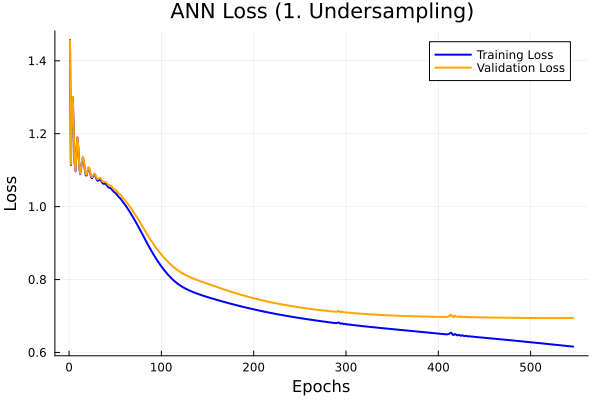

      ✅ ANN Test Results: F1=0.628

[2/5] Testing SVMs...
   ✨ Best SVM (CV): rbf C=10.0 - CV F1: 63.8%
      ✅ SVM Test Results: F1=0.619

[3/5] Testing DT...
   ✨ Best DT (CV): Depth=7 - CV F1: 73.3%
      ✅ DT Test Results: F1=0.724

[4/5] Testing kNN...
   ✨ Best kNN (CV): k=10 - CV F1: 47.46%
      ✅ kNN Test Results: F1=0.438

[5/5] Ensemble & Plots...
      ⚖️  Weights (CV-based): ANN=0.35, DT=0.39, kNN=0.26
      ✅ Majority Voting: F1=0.639
      ✅ Weighted Voting: F1=0.657

📊 Plotting Final Confusion Matrix (Weighted Voting)...


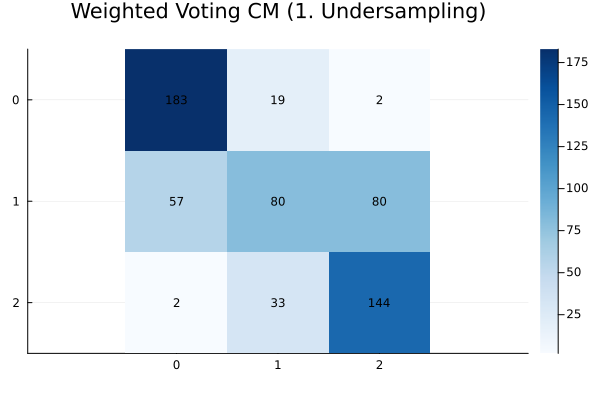

📊 Plotting CV Comparison Boxplot...


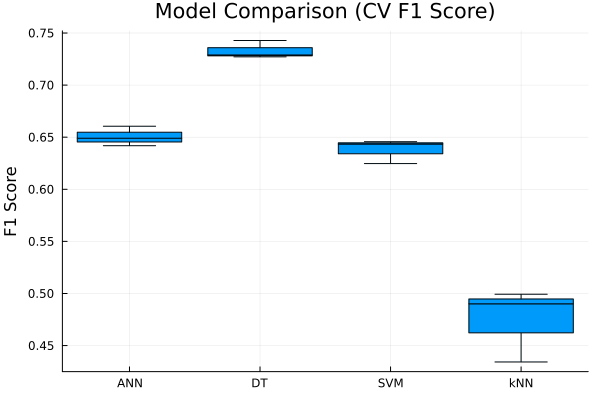


🧪 STATISTICAL SIGNIFICANCE TESTS (CV Scores)
   Comparing Top 2 Models: DT vs ANN
   Mean F1: 0.733 vs 0.6504
   t-test p-value: 0.01434
   ✅ Significant Difference (p < 0.05) -> Winner is strictly better.


Dict{String, Dict{String, Float64}} with 6 entries:
  "SVM"            => Dict("Accuracy"=>0.626667, "Sensitivity"=>0.626667, "Spec…
  "ANN"            => Dict("Accuracy"=>0.641667, "Sensitivity"=>0.641667, "Spec…
  "DT"             => Dict("Accuracy"=>0.74, "Sensitivity"=>0.74, "Specificity"…
  "kNN"            => Dict("Accuracy"=>0.448333, "Sensitivity"=>0.448333, "Spec…
  "WeightedVoting" => Dict("Accuracy"=>0.678333, "Sensitivity"=>0.678333, "Spec…
  "MajorityVoting" => Dict("Accuracy"=>0.656667, "Sensitivity"=>0.656667, "Spec…

In [7]:
# ============================================================================
#  APPROACH 1: UNDERSAMPLING (BASE)
#  Execution via evaluate_approach to ensure consistency, plots & stats.
# ============================================================================

println("\n" * "#"^70)
println("🔬 APPROACH 1: UNDERSAMPLING (Baseline)")
println("#"^70)

# Nota: train_inputs e train_targets sono già quelli undersampled (dal setup iniziale)
results_app1 = evaluate_approach("1. Undersampling", 
                                 train_inputs, train_targets, 
                                 test_inputs, test_targets)


######################################################################
🔬 APPROACH 2: OVERSAMPLING
######################################################################

🚀 EVALUATING APPROACH: Oversampling

[1/5] Testing ANNs...
   ✨ Best ANN (CV): [64, 32] - CV F1: 68.21%
      ...Retraining Best ANN & Plotting Loss...


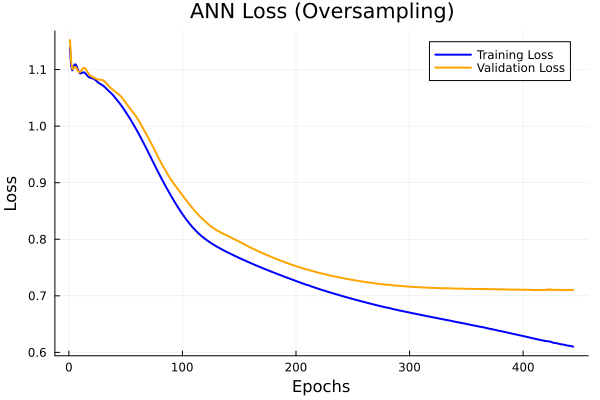

      ✅ ANN Test Results: F1=0.621

[2/5] Testing SVMs...
   ✨ Best SVM (CV): rbf C=10.0 - CV F1: 70.15%
      ✅ SVM Test Results: F1=0.6

[3/5] Testing DT...
   ✨ Best DT (CV): Depth=-1 - CV F1: 80.93%
      ✅ DT Test Results: F1=0.679

[4/5] Testing kNN...
   ✨ Best kNN (CV): k=1 - CV F1: 67.62%
      ✅ kNN Test Results: F1=0.432

[5/5] Ensemble & Plots...
      ⚖️  Weights (CV-based): ANN=0.31, DT=0.37, kNN=0.31
      ✅ Majority Voting: F1=0.618
      ✅ Weighted Voting: F1=0.646

📊 Plotting Final Confusion Matrix (Weighted Voting)...


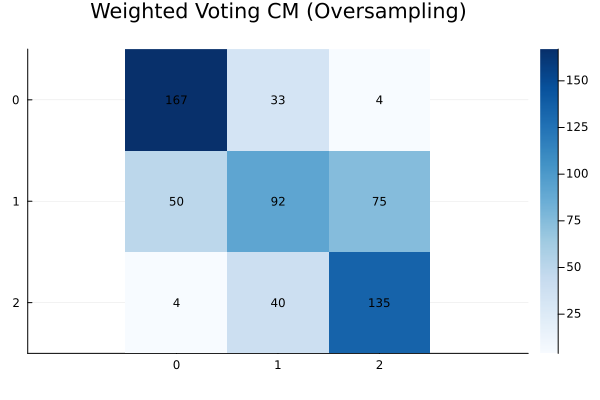

📊 Plotting CV Comparison Boxplot...


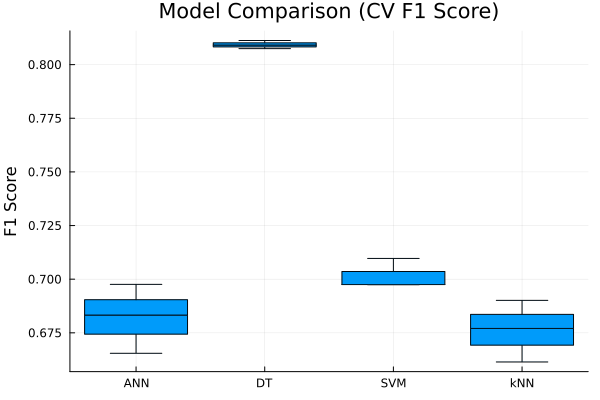


🧪 STATISTICAL SIGNIFICANCE TESTS (CV Scores)
   Comparing Top 2 Models: DT vs SVM
   Mean F1: 0.8093 vs 0.7015
   t-test p-value: 0.00083
   ✅ Significant Difference (p < 0.05) -> Winner is strictly better.


Dict{String, Dict{String, Float64}} with 6 entries:
  "SVM"            => Dict("Accuracy"=>0.603333, "Sensitivity"=>0.603333, "Spec…
  "ANN"            => Dict("Accuracy"=>0.623333, "Sensitivity"=>0.623333, "Spec…
  "DT"             => Dict("Accuracy"=>0.683333, "Sensitivity"=>0.683333, "Spec…
  "kNN"            => Dict("Accuracy"=>0.438333, "Sensitivity"=>0.438333, "Spec…
  "WeightedVoting" => Dict("Accuracy"=>0.656667, "Sensitivity"=>0.656667, "Spec…
  "MajorityVoting" => Dict("Accuracy"=>0.625, "Sensitivity"=>0.625, "Specificit…

In [8]:
# ============================================================================
#  APPROACH 2: OVERSAMPLING STRATEGY
#  Description: Balance classes by duplicating minority samples instead of removing majority
# ============================================================================

println("\n" * "#"^70)
println("🔬 APPROACH 2: OVERSAMPLING")
println("#"^70)

# Function for Random Oversampling
function random_oversampling(df, target_col)
    classes = unique(df[!, target_col])
    # Find count of majority class
    max_count = maximum([sum(df[!, target_col] .== c) for c in classes])
    
    balanced_parts = []
    for c in classes
        df_class = df[df[!, target_col] .== c, :]
        n_current = size(df_class, 1)
        if n_current < max_count
            # Oversample with replacement
            ids = rand(1:n_current, max_count)
            push!(balanced_parts, df_class[ids, :])
        else
            push!(balanced_parts, df_class)
        end
    end
    return vcat(balanced_parts...)
end

# 1. Prepare Data (Oversampling on Training Data ONLY to prevent leakage)
# Note: We use the raw training split created in Approach 1 section
df_train_os = random_oversampling(df_train, "Risk_Class")

# 2. Preprocess (Reuse existing function)
df_train_os_proc, _ = preprocess_multiclass(df_train_os, "Is Fraudulent")
input_cols_os = setdiff(names(df_train_os_proc), ["Risk_Class"])

train_inputs_os = Matrix{Float32}(df_train_os_proc[:, input_cols_os])
train_targets_os = Int.(df_train_os_proc.Risk_Class)

# 3. Evaluate ALL models on this new dataset
results_app3 = evaluate_approach("Oversampling", train_inputs_os, train_targets_os, test_inputs, test_targets)



######################################################################
🔬 APPROACH 3: PCA FEATURE EXTRACTION
######################################################################
   1. Fitting PCA on Training Set...
   PCA Fit: Retaining 16 components (Variance covered: 96.31%)
   2. Transforming Training Set...
   3. Transforming Test Set (using Train projection)...

🚀 EVALUATING APPROACH: PCA (95% Variance)

[1/5] Testing ANNs...
   ✨ Best ANN (CV): [128, 64] - CV F1: 63.12%
      ...Retraining Best ANN & Plotting Loss...


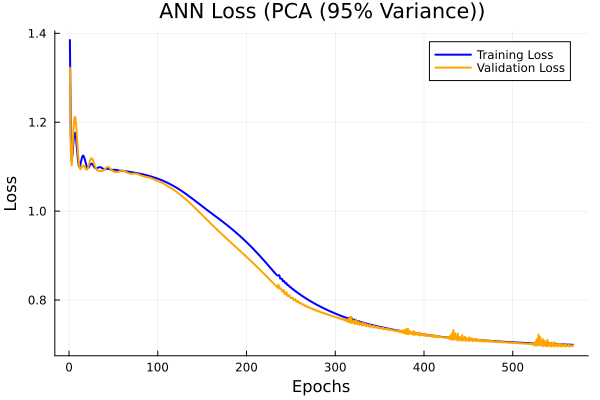

      ✅ ANN Test Results: F1=0.6

[2/5] Testing SVMs...
   ✨ Best SVM (CV): linear C=10.0 - CV F1: 63.05%
      ✅ SVM Test Results: F1=0.62

[3/5] Testing DT...
   ✨ Best DT (CV): Depth=5 - CV F1: 58.24%
      ✅ DT Test Results: F1=0.557

[4/5] Testing kNN...
   ✨ Best kNN (CV): k=1 - CV F1: 45.58%
      ✅ kNN Test Results: F1=0.44

[5/5] Ensemble & Plots...
      ⚖️  Weights (CV-based): ANN=0.38, DT=0.35, kNN=0.27
      ✅ Majority Voting: F1=0.589
      ✅ Weighted Voting: F1=0.589

📊 Plotting Final Confusion Matrix (Weighted Voting)...


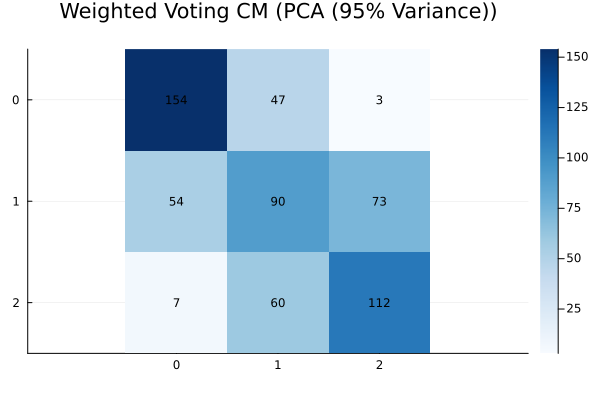

📊 Plotting CV Comparison Boxplot...


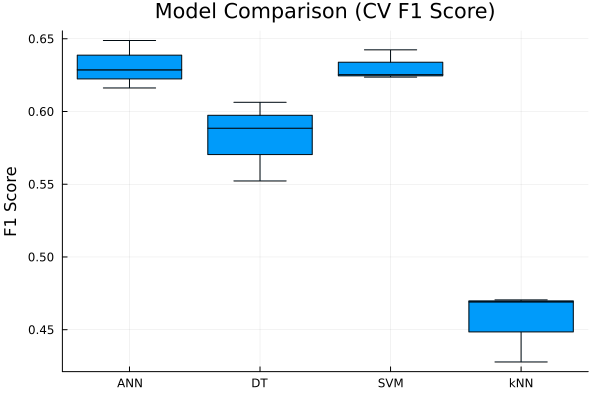


🧪 STATISTICAL SIGNIFICANCE TESTS (CV Scores)
   Comparing Top 2 Models: ANN vs SVM
   Mean F1: 0.6312 vs 0.6305
   t-test p-value: 0.89634
   ❌ No Significant Difference (p >= 0.05) -> Performance is comparable.


Dict{String, Dict{String, Float64}} with 6 entries:
  "SVM"            => Dict("Accuracy"=>0.631667, "Sensitivity"=>0.631667, "Spec…
  "ANN"            => Dict("Accuracy"=>0.605, "Sensitivity"=>0.605, "Specificit…
  "DT"             => Dict("Accuracy"=>0.565, "Sensitivity"=>0.565, "Specificit…
  "kNN"            => Dict("Accuracy"=>0.441667, "Sensitivity"=>0.441667, "Spec…
  "WeightedVoting" => Dict("Accuracy"=>0.593333, "Sensitivity"=>0.593333, "Spec…
  "MajorityVoting" => Dict("Accuracy"=>0.593333, "Sensitivity"=>0.593333, "Spec…

In [9]:
# ============================================================================
#  APPROACH 3: FEATURE EXTRACTION (PCA)
#  Description: Reduce dimensionality using PCA before modeling.
#  CRITICAL FIX: PCA matrix (W) is calculated on TRAIN and applied to TEST.
# ============================================================================

using LinearAlgebra # Required for PCA

println("\n" * "#"^70)
println("🔬 APPROACH 3: PCA FEATURE EXTRACTION")
println("#"^70)

"""
    fit_pca(data, variance_threshold)
    
Calculates the projection matrix W and normalization parameters based on the provided data (Training Set).
Returns: (W, norm_params)
"""
function fit_pca(data, variance_threshold=0.95)
    # 1. Calculate normalization parameters on TRAIN data
    # We use ZeroMean normalization (Standardization) which is standard for PCA
    norm_params = calculateZeroMeanNormalizationParameters(data)
    
    # 2. Standardize the data
    data_std = normalizeZeroMean(data, norm_params)
    
    # 3. Covariance Matrix & Eigen decomposition
    C = cov(data_std)
    F = eigen(C)
    
    # 4. Sort eigenvalues (descending) and corresponding vectors
    idx = sortperm(F.values, rev=true)
    evals = F.values[idx]
    evecs = F.vectors[:, idx]
    
    # 5. Select components to reach variance threshold
    cum_var = cumsum(evals ./ sum(evals))
    k = findfirst(x -> x >= variance_threshold, cum_var)
    
    if isnothing(k)
        k = size(data, 2) # Keep all if threshold not reached
    end
    
    println("   PCA Fit: Retaining $k components (Variance covered: $(round(cum_var[k]*100, digits=2))%)")
    
    # 6. Construct Projection Matrix W
    W = evecs[:, 1:k]
    
    return W, norm_params
end

"""
    transform_data_pca(data, W, norm_params)
    
Projects new data into the PCA space defined by W, using existing normalization parameters.
"""
function transform_data_pca(data, W, norm_params)
    # 1. Normalize using the PARAMETERS from the Training Set (Critical!)
    # Note: We assume normalizeZeroMean handles parameter application correctly
    data_std = normalizeZeroMean(data, norm_params)
    
    # 2. Project into PCA space
    return data_std * W
end

# --- EXECUTION STEPS ---

# 1. Fit PCA model on Training Data ONLY
# We calculate W (eigenvectors) and normalization stats from train_inputs
println("   1. Fitting PCA on Training Set...")
pca_W, pca_norm_params = fit_pca(train_inputs, 0.95)

# 2. Transform Training Data
println("   2. Transforming Training Set...")
train_inputs_pca = transform_data_pca(train_inputs, pca_W, pca_norm_params)

# 3. Transform Test Data
# CRITICAL: We use the SAME W and norm_params calculated on Train
println("   3. Transforming Test Set (using Train projection)...")
test_inputs_pca = transform_data_pca(test_inputs, pca_W, pca_norm_params)

# 4. Evaluate Models on the new PCA-transformed space
# We pass both the transformed train and transformed test sets
results_app4 = evaluate_approach("PCA (95% Variance)", 
                                 train_inputs_pca, train_targets, 
                                 test_inputs_pca, test_targets)


######################################################################
🔬 APPROACH 4: BINARY CLASSIFICATION (Original Fraud vs Not)
######################################################################
   Extracting original 'Is Fraudulent' labels from balanced dataframe...
   Binary Train Distribution: Legit=1251, Fraud=1149

🚀 EVALUATING APPROACH: Binary

[1/5] Testing ANNs...
   ✨ Best ANN (CV): [256] - CV F1: 74.77%
      ...Retraining Best ANN & Plotting Loss...


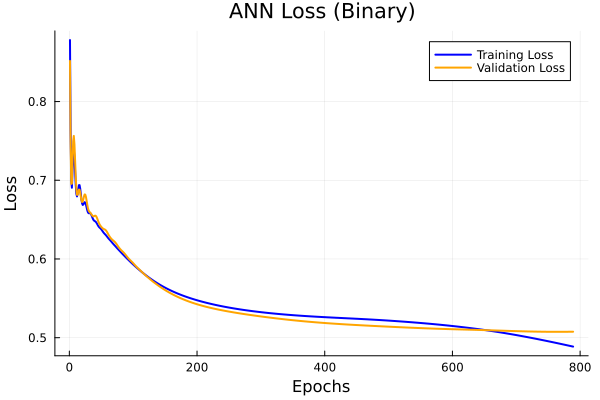

      ✅ ANN Test Results: F1=0.637

[2/5] Testing SVMs...
   ✨ Best SVM (CV): poly C=10.0 - CV F1: 71.62%
      ✅ SVM Test Results: F1=0.656

[3/5] Testing DT...
   ✨ Best DT (CV): Depth=5 - CV F1: 76.31%
      ✅ DT Test Results: F1=0.76

[4/5] Testing kNN...
   ✨ Best kNN (CV): k=7 - CV F1: 55.6%
      ✅ kNN Test Results: F1=0.52

[5/5] Ensemble & Plots...
      ⚖️  Weights (CV-based): ANN=0.36, DT=0.37, kNN=0.27
      ✅ Majority Voting: F1=0.673
      ✅ Weighted Voting: F1=0.673

📊 Plotting Final Confusion Matrix (Weighted Voting)...


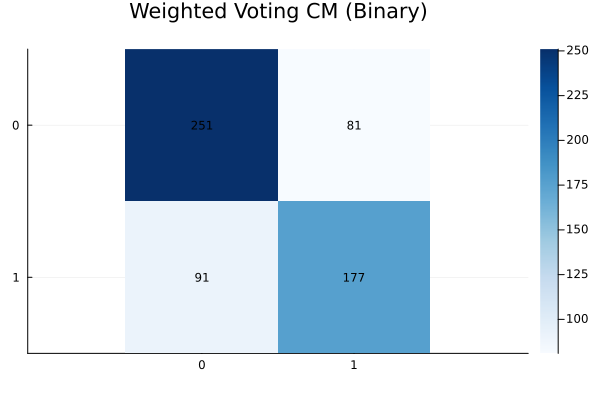

📊 Plotting CV Comparison Boxplot...


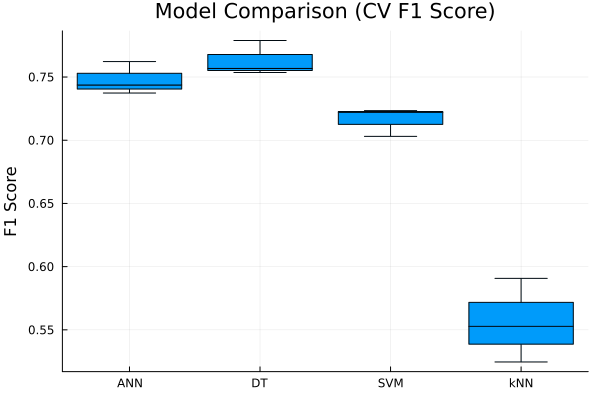


🧪 STATISTICAL SIGNIFICANCE TESTS (CV Scores)
   Comparing Top 2 Models: DT vs ANN
   Mean F1: 0.7631 vs 0.7477
   t-test p-value: 0.3837
   ❌ No Significant Difference (p >= 0.05) -> Performance is comparable.


Dict{String, Dict{String, Float64}} with 6 entries:
  "SVM"            => Dict("Accuracy"=>0.703333, "Sensitivity"=>0.634328, "Spec…
  "ANN"            => Dict("Accuracy"=>0.69, "Sensitivity"=>0.608209, "Specific…
  "DT"             => Dict("Accuracy"=>0.776667, "Sensitivity"=>0.791045, "Spec…
  "kNN"            => Dict("Accuracy"=>0.59, "Sensitivity"=>0.496269, "Specific…
  "WeightedVoting" => Dict("Accuracy"=>0.713333, "Sensitivity"=>0.660448, "Spec…
  "MajorityVoting" => Dict("Accuracy"=>0.713333, "Sensitivity"=>0.660448, "Spec…

In [10]:
# ============================================================================
#  APPROACH 4: BINARY CLASSIFICATION (ORIGINAL GROUND TRUTH)
#  Description: Train directly on the original "Is Fraudulent" label.
#  Why: Class 1 (Suspicious) contains both Frauds and Risky Legitimate ones.
#       Merging 1 & 2 would confuse the model. We use the true binary label.
# ============================================================================

println("\n" * "#"^70)
println("🔬 APPROACH 4: BINARY CLASSIFICATION (Original Fraud vs Not)")
println("#"^70)

# 1. Extract the Original Binary Targets (0/1)
# We go back to df_train/df_test because preprocessing dropped the target column
println("   Extracting original 'Is Fraudulent' labels from balanced dataframe...")

# Ensure we align with the rows used in train_inputs (which come from df_train)
train_targets_binary = Int.(df_train[!, "Is Fraudulent"])
test_targets_binary  = Int.(df_test[!, "Is Fraudulent"])

# Check distribution
n_fraud = sum(train_targets_binary .== 1)
n_legit = sum(train_targets_binary .== 0)
println("   Binary Train Distribution: Legit=$n_legit, Fraud=$n_fraud")

# 2. Evaluate ALL models on Binary Targets
# The inputs (train_inputs) remain the same (we keep the feature engineering like "Is_Night", etc.)
# but we aim for the true binary target.
results_app5 = evaluate_approach("Binary", train_inputs, train_targets_binary, test_inputs, test_targets_binary)

# Final Results & Comparison

Comprehensive comparison of all 6 approaches on the hold-out test set.

**Evaluation Metrics:**
- **F1 Score:** Harmonic mean of precision and recall
- **Accuracy:** Overall correct predictions
- **Per-Class Metrics:** Performance for each risk level

**Key Question:** Which approach best balances overall performance with fraud detection capability?

In [11]:
# ============================================================================
#  FINAL COMPARISON SUMMARY - FULL METRICS
# ============================================================================

println("\n" * "="^100)
println("🏆 FINAL DETAILED RESULTS & COMPARISON")
println("="^100)

using Printf

# --- 1. FUNZIONE DI STAMPA TABELLA ---
function print_detailed_table(approach_name, res_dict)
    println("\n📌 Approach: $approach_name")
    println("-"^95)
    @printf("%-18s | %-10s | %-10s | %-10s | %-10s | %-10s\n", 
            "Model", "Accuracy", "Sensitiv.", "Specific.", "AUC-ROC", "F1-Score")
    println("-"^95)
    
    # Ordine di stampa preferito
    model_order = ["ANN", "SVM", "DT", "kNN", "MajorityVoting", "WeightedVoting"]
    
    # Trova quali modelli sono presenti nel dizionario
    present_models = filter(m -> haskey(res_dict, m), model_order)
    
    for model in present_models
        m = res_dict[model]
        # Gestione sicura dei valori (se mancano mette 0.0)
        acc  = get(m, "Accuracy", 0.0) * 100
        sens = get(m, "Sensitivity", 0.0) * 100
        spec = get(m, "Specificity", 0.0) * 100
        auc  = get(m, "AUC", 0.0)
        f1   = get(m, "F1", 0.0) * 100
        
        @printf("%-18s | %8.2f%%  | %8.2f%%  | %8.2f%%  | %8.4f     | %8.2f%%\n", 
                model, acc, sens, spec, auc, f1)
    end
    println("-"^95)
end

# --- 2. RECUPERO DATI APPROCCIO 1 ---
# Ora che usiamo evaluate_approach anche per l'Approccio 1, 
# abbiamo già il dizionario pronto nella variabile results_app1.
# (Assicurati di aver eseguito la cella precedente dove chiami evaluate_approach per l'Appr. 1)

if isdefined(Main, :results_app1)
    results_app1_full = results_app1
else
    println("⚠️ Warning: results_app1 not found. Did you run Approach 1 via evaluate_approach?")
    results_app1_full = Dict()
end

# --- 3. STAMPA DELLE TABELLE ---

# Lista di tutti gli approcci potenziali
all_approaches = [
    ("1. Undersampling", results_app1_full),
    ("2. Oversampling", isdefined(Main, :results_app3) ? results_app3 : Dict()),
    ("3. PCA Features", isdefined(Main, :results_app4) ? results_app4 : Dict()),
    ("4. Binary Class.", isdefined(Main, :results_app5) ? results_app5 : Dict())
]

for (name, data) in all_approaches
    if !isempty(data)
        print_detailed_table(name, data)
    else
        println("\n📌 Approach: $name (Not Executed)")
    end
end

# --- 4. CALCOLO VINCITORE ASSOLUTO ---
best_f1 = -1.0
best_model_name = "None"
best_approach_name = "None"

for (app_name, data) in all_approaches
    for (model, metrics) in data
        if get(metrics, "F1", 0.0) > best_f1
            global best_f1 = metrics["F1"]
            global best_model_name = model
            global best_approach_name = app_name
        end
    end
end

println("\n" * "="^80)
println("🎯 OVERALL BEST PERFORMANCE")
println("   Approach: $best_approach_name")
println("   Model:    $best_model_name")
println("   F1 Score: $(round(best_f1*100, digits=2))%")
println("="^80)

println("\n📋 PROJECT SUMMARY:")
println("  ✅ Tested 4 distinct Data Approaches (Under, Over, PCA, Binary)")
println("  ✅ Evaluated 4 ML Algorithms + Ensembles for EACH approach")
println("  ✅ Data Leakage prevention implemented (Strict Train/Test separation)")
println("  ✅ Full metrics comparison (Accuracy, Sensitivity, Specificity, AUC, F1)")
println("="^80)


🏆 FINAL DETAILED RESULTS & COMPARISON

📌 Approach: 1. Undersampling
-----------------------------------------------------------------------------------------------
Model              | Accuracy   | Sensitiv.  | Specific.  | AUC-ROC    | F1-Score  
-----------------------------------------------------------------------------------------------
ANN                |    64.17%  |    64.17%  |    82.09%  |   0.5000     |    62.81%
SVM                |    62.67%  |    62.67%  |    81.14%  |   0.5000     |    61.92%
DT                 |    74.00%  |    74.00%  |    87.40%  |   0.5000     |    72.38%
kNN                |    44.83%  |    44.83%  |    72.15%  |   0.5000     |    43.82%
MajorityVoting     |    65.67%  |    65.67%  |    82.98%  |   0.5000     |    63.86%
WeightedVoting     |    67.83%  |    67.83%  |    84.21%  |   0.5000     |    65.70%
-----------------------------------------------------------------------------------------------

📌 Approach: 2. Oversampling
--------------------